# Model Examples built with Xarray-Simlab

From: https://xarray-simlab.readthedocs.io/

# Installation and Setup

This notebook is designed to be run from:   
- a custom [conda](https://docs.conda.io/en/latest/) virtual environment as described in our [Install Development Environment](benchmark/readme.md) instructions, especially including:
  - Creating a custom virtual environment using the `environment.yml` file included in this folder (step 3)
  - Adding this repository to your conda path (step 4)

In [1]:
from pathlib import Path

import numpy as np
# import xsimlab as xs, done below using conda develop

import matplotlib.pyplot as plt

## Set Paths to Source Code and  Input/Output Files with `pathlib` 

Use the [pathlib](https://docs.python.org/3/library/pathlib.html) library (built-in to Python 3) to manage paths indpendentely of OS or environment. See this [blog post](https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f) to learn about the many benefits over using the `os` library.

In [2]:
# Find your current working directory, which should be folder for this notebook.
working_dir = Path.cwd()

project_path = working_dir.parent.parent
project_path

PosixPath('/Users/aaufdenkampe/Documents/Python/ClearWater-modules')

In [3]:
# If xarray-simlab is installed in the same directory as this project, 
# then this should be the source directory
xsimlab_source_path = project_path.parent / 'xarray-simlab' 
xsimlab_source_path.exists()

True

### To install in developer mode:
- Confirm that the output of `src_path` points to the MF6RTM `src` directory 
- Uncomment and run the line below.
- NOTE 1: The Jupyter [`%conda` magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-conda) runs conda terminal commands directly from this notebook.
- NOTE 2: We can inject Python string objects into magic commmands using a syntax similar to Python's F-strings.

In [ ]:
# %conda develop {xsimlab_source_path}

path exists, skipping /Users/aaufdenkampe/Documents/Python/xarray-simlab
completed operation for: /Users/aaufdenkampe/Documents/Python/xarray-simlab

Note: you may need to restart the kernel to use updated packages.


If the path was added, Restart the kernel and rerun the cells above.

In [5]:
import xsimlab as xs

## Conway’s Game of Life example
https://xarray-simlab.readthedocs.io/en/latest/about.html

### 1. Create new model components by writing compact Python classes, 

i.e., very much like dataclasses (note: more features and Python < 3.7 support are also available through the attrs library):

In [6]:
@xs.process
class GameOfLife:
    world = xs.variable(
        dims=('x', 'y'), intent='inout', encoding={'fill_value': None}
    )

    def run_step(self):
        nbrs_count = sum(
            np.roll(np.roll(self.world, i, 0), j, 1)
            for i in (-1, 0, 1) for j in (-1, 0, 1)
            if (i != 0 or j != 0)
        )
        self._world_next = (nbrs_count == 3) | (self.world & (nbrs_count == 2))

    def finalize_step(self):
        self.world[:] = self._world_next


@xs.process
class Glider:
    pos = xs.variable(dims='point_xy', description='glider position')
    world = xs.foreign(GameOfLife, 'world', intent='out')

    def initialize(self):
        x, y = self.pos

        kernel = [[1, 0, 0],
                  [0, 1, 1],
                  [1, 1, 0]]

        self.world = np.zeros((10, 10), dtype=bool)
        self.world[x:x+3, y:y+3] = kernel

### 2. Create a new model just by providing a dictionary of model components:

In [7]:
model = xs.Model({'gol': GameOfLife,
                  'init': Glider})

### 3. Create an input xarray.Dataset, run the model and get an output Dataset:

In [8]:
input_dataset = xs.create_setup(
    model=model,
    clocks={'step': np.arange(9)},
    input_vars={'init__pos': ('point_xy', [4, 5])},
    output_vars={'gol__world': 'step'}
)

/Users/aaufdenkampe/Documents/Python/xarray-simlab/xsimlab/xr_accessor.py:259: FutureWarning: variable 'step' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [9]:
%time
output_dataset = input_dataset.xsimlab.run(model=model)
output_dataset

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 2.86 μs


<xarray.Dataset> Size: 988B
Dimensions:     (step: 9, x: 10, y: 10, point_xy: 2)
Coordinates:
  * step        (step) int64 72B 0 1 2 3 4 5 6 7 8
Dimensions without coordinates: x, y, point_xy
Data variables:
    gol__world  (step, x, y) bool 900B False False False ... False False False
    init__pos   (point_xy) int64 16B 4 5

### 4. Perform model setup, pre-processing, run, post-processing and visualization in a functional style, using method chaining:


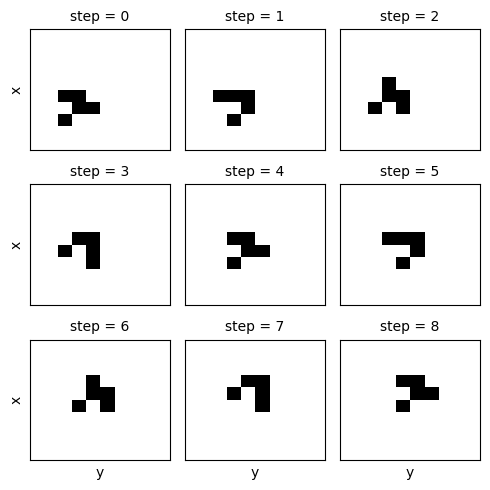

In [10]:
with model:
    (input_dataset
     .xsimlab.update_vars(
         input_vars={'init__pos': ('point_xy', [2, 2])}
     )
     .xsimlab.run()
     .gol__world.plot.imshow(
         col='step', col_wrap=3, figsize=(5, 5),
         xticks=[], yticks=[],
         add_colorbar=False, cmap=plt.cm.binary)
    )


# 1-d advection equation using the Lax method

https://xarray-simlab.readthedocs.io/en/latest/create_model.html

### Old-school approach to model

In [11]:
# grid
spacing = 0.01
length = 1.5
x = np.arange(0, length, spacing)

# velocity
v = 1.0

# time
start = 0.0
end = 1.0
step = 0.01

# initial gauss profile
loc = 0.3
scale = 0.1
u = np.exp(-1 / scale ** 2 * (x - loc) ** 2)
u0 = u.copy()

# time loop - Lax method
factor = (v * step) / (2 * spacing)

for t in np.arange(start, end, step):
    u_left = np.roll(u, 1)
    u_right = np.roll(u, -1)
    u1 = 0.5 * (u_right + u_left) - factor * (u_right - u_left)
    u = u1.copy()

## Refactored into an xsimlab single-Process model
https://xarray-simlab.readthedocs.io/en/latest/create_model.html


In [12]:
@xs.process
class AdvectionLax1D:
    """Wrap 1-dimensional advection in a single Process."""

    spacing = xs.variable(description="grid spacing", static=True)
    length = xs.variable(description="grid total length", static=True)
    x = xs.variable(dims="x", intent="out")

    v = xs.variable(dims=[(), "x"], description="velocity")

    loc = xs.variable(description="location of initial profile", static=True)
    scale = xs.variable(description="scale of initial profile", static=True)
    u = xs.variable(
        dims="x", intent="out", description="quantity u", attrs={"units": "m"}
    )

    def initialize(self):
        # self.spacing = 0.01
        # self.length = 1.5
        # self.v = 1.0
        # self.loc = 0.3
        # self.scale = 0.1
        self.x = np.arange(0, self.length, self.spacing)
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = (self.v * dt) / (2 * self.spacing)
        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        self.u1 = 0.5 * (u_right + u_left) - factor * (u_right - u_left)

    def finalize_step(self):
        self.u = self.u1

In [13]:
advect_model_raw = xs.Model({"advect": AdvectionLax1D})
advect_model_raw

<xsimlab.Model (1 processes, 5 inputs)>
advect
    spacing     [in] grid spacing
    length      [in] grid total length
    v           [in] () or ('x',) velocity
    loc         [in] location of initial profile
    scale       [in] scale of initial profile

## Fine-grained process refactoring

https://xarray-simlab.readthedocs.io/en/latest/create_model.html#creating-a-model-instance

https://xarray-simlab.readthedocs.io/en/latest/run_model.html#create-a-new-setup-from-scratch

In [14]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [15]:
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u

In [16]:
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

In [17]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [18]:
advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

In [19]:
advect_model

<xsimlab.Model (4 processes, 5 inputs)>
grid
    spacing     [in] uniform spacing
    length      [in] total length
init
    loc         [in] location of initial pulse
    scale       [in] scale of initial pulse
advect
    v           [in] () or ('x',) velocity
profile

### Inpsect Models

https://xarray-simlab.readthedocs.io/en/latest/inspect_model.html#

In [20]:
advect_model.input_vars

[('grid', 'spacing'),
 ('grid', 'length'),
 ('init', 'loc'),
 ('init', 'scale'),
 ('advect', 'v')]

In [21]:
advect_model.input_vars_dict

{'grid': ['spacing', 'length'], 'init': ['loc', 'scale'], 'advect': ['v']}

In [22]:
xs.process_info(ProfileU)

<ProfileU  (xsimlab process)>
Variables:
    u_vars      [in] <--- group 'u_vars'
    u        [inout] ('x',) quantity u
Simulation stages:
    run_step
    finalize_step


In [23]:
xs.variable_info(ProfileU, 'u')

Quantity u

Variable properties:

- type : ``variable``
- intent : ``inout``
- dimensions : ('x',)

Other attributes:

- units : m


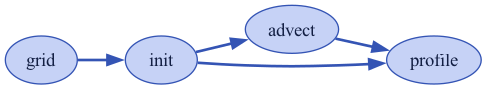

In [24]:
advect_model.visualize()

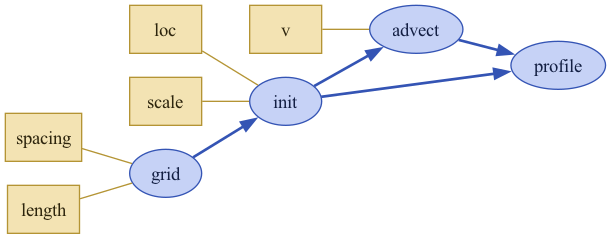

In [25]:
advect_model.visualize(show_inputs=True)

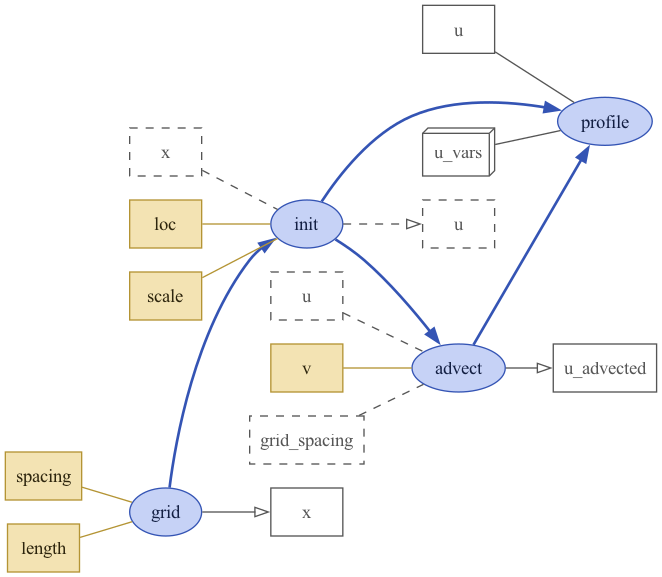

In [26]:
advect_model.visualize(show_inputs=True, show_variables=True)

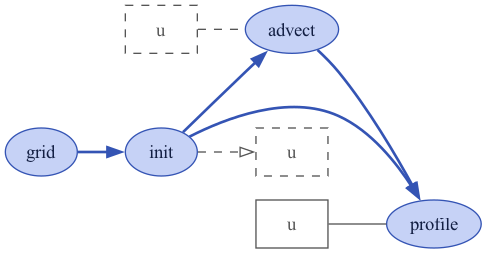

In [27]:
advect_model.visualize(show_only_variable=('profile', 'u'))

### Setup and Run

https://xarray-simlab.readthedocs.io/en/latest/run_model.html#create-a-new-setup-from-scratch

Note: if 

In [28]:
in_ds = xs.create_setup(
    model=advect_model,
    clocks={
        'time': np.linspace(0., 1., 101),
        'otime': [0, 0.5, 1]
    },
    master_clock='time',
    input_vars={
        'grid': {'length': 1.5, 'spacing': 0.01},
        'init': {'loc': 0.3, 'scale': 0.1},
        'advect__v': 1.
    },
    output_vars={
        'profile__u': 'otime'
    }
)
in_ds

/Users/aaufdenkampe/Documents/Python/xarray-simlab/xsimlab/xr_accessor.py:955: FutureWarning: master_clock is to be deprecated in favour of main_clock
  warnings.warn(
/Users/aaufdenkampe/Documents/Python/xarray-simlab/xsimlab/xr_accessor.py:259: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/Users/aaufdenkampe/Documents/Python/xarray-simlab/xsimlab/xr_accessor.py:259: FutureWarning: variable 'otime' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


<xarray.Dataset> Size: 872B
Dimensions:        (time: 101, otime: 3)
Coordinates:
  * time           (time) float64 808B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
  * otime          (otime) float64 24B 0.0 0.5 1.0
Data variables:
    grid__length   float64 8B 1.5
    grid__spacing  float64 8B 0.01
    init__loc      float64 8B 0.3
    init__scale    float64 8B 0.1
    advect__v      float64 8B 1.0

In [29]:
in_ds.advect__v

<xarray.DataArray 'advect__v' ()> Size: 8B
array(1.)
Attributes:
    description:  velocity

In [30]:
out_ds = in_ds.xsimlab.run(model=advect_model)
out_ds

<xarray.Dataset> Size: 6kB
Dimensions:        (otime: 3, x: 150, time: 101)
Coordinates:
  * otime          (otime) float64 24B 0.0 0.5 1.0
  * time           (time) float64 808B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
  * x              (x) float64 1kB 0.0 0.01 0.02 0.03 ... 1.46 1.47 1.48 1.49
Data variables:
    advect__v      float64 8B 1.0
    grid__length   float64 8B 1.5
    grid__spacing  float64 8B 0.01
    init__loc      float64 8B 0.3
    init__scale    float64 8B 0.1
    profile__u     (otime, x) float64 4kB 0.0001234 0.0002226 ... 0.02705

### Update inputs

In [31]:
in_vars = {('advect', 'v'): 0.5}

with advect_model:
    out_ds2 = (in_ds.xsimlab.update_vars(input_vars=in_vars)
                    .xsimlab.run())

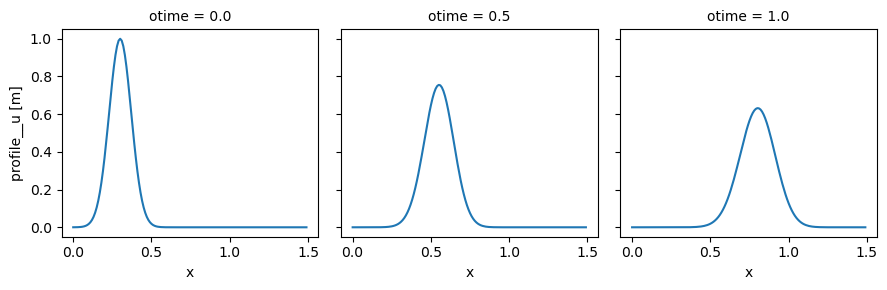

In [32]:
out_ds2.profile__u.plot(col='otime', figsize=(9, 3));

# END